# Workflow for handling cluster data

We import the whole data set into a dataframe

In [8]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Fri Oct 23 13:58:22 2020

@author: jacob
"""

import sys
import math
import numpy as np
import pandas as pd
from umap import UMAP
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.manifold import MDS
from sklearn.manifold import TSNE
from sklearn.manifold import Isomap
from sklearn.decomposition import PCA
from sklearn.decomposition import NMF
from sklearn.decomposition import FastICA
from sklearn.decomposition import KernelPCA
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import SpectralEmbedding
from sklearn.decomposition import FactorAnalysis
from sklearn.ensemble import RandomTreesEmbedding
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import numpy as np
import pandas as pd

df = pd.read_csv("/home/jacob/examensarbete/software/data/LUAD_GeneExpData_mc_log2var(50).txt", delimiter = '\t')
df = df.set_index(['gene_id'])
pIndex = list(df.index)
index = list(df.index)
index.append('Clusters')

Set the directory to where the data is

In [9]:
import os
importDirectory = '/home/jacob/examensarbete/software/output/5000/QC_Spiral(false)/dist(0.75)/5'
clusters = dict()
allClusters = list()

All the samples are saved together in a big list, and the indvidual cluster are saved in list of lists.

In [10]:

for filename in os.listdir(importDirectory):
    key = filename[1:]
    string = ''
    with open(os.path.join(importDirectory, filename)) as file:
        for line in file.readlines():
            string = string + line
            if line.strip() != 'gene_id': allClusters.append(line.strip())
        string.replace('gene_id', '')
        string = string.split()
        string.pop(0)
        clusters[filename] = string
   

We the filter out all the samples that arent in any clusters and later we assign them to the correct cluster.

In [11]:
allClusters = list(dict.fromkeys(allClusters))
df = df.filter(items=allClusters)
dicts = dict()

for i in range(len(clusters)):
    for sample in clusters['{}{}'.format(i+1, key)]:
        dicts[sample] = i+1

df = df.append(dicts, ignore_index= True)

df = df.set_index([index])



And voila! The data is formatted for PCA

In [12]:
newDf = pd.DataFrame()
for i in range(len(clusters)):
    for sample in clusters['{}{}'.format(i+1, key)]:
        newDf[sample] = df[sample]
newDf = newDf.set_index([index])
df = newDf 
tDf = df.transpose()

# Visualization of data

First we import some tools to do a PCA on the genomic data.
We create a model and some principal components which we plot in a scree plot.

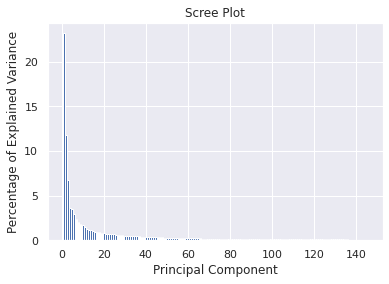

In [133]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

pca = PCA()
pca.fit(tDf.drop(['Clusters'],axis=1))
pca_data = pca.transform(tDf.drop(['Clusters'],axis=1))

per_var = np.round(pca.explained_variance_ratio_* 100, decimals=1)
labels = ['PC' + str(x) for x in range(1, len(per_var)+1)]

plt.bar(x=range(1,len(per_var)+1), height=per_var)
plt.ylabel('Percentage of Explained Variance')
plt.xlabel('Principal Component')
plt.title('Scree Plot')
plt.show()

We see that around the first 3 components desribe ~40% of the variance.
We the construct a dataframe from the principal components.

In [134]:
pca_df = pd.DataFrame(pca_data,  columns=labels)
pca_df = pca_df.join(tDf.filter(['Clusters']).reset_index())

And we plot the components in a scatterplot

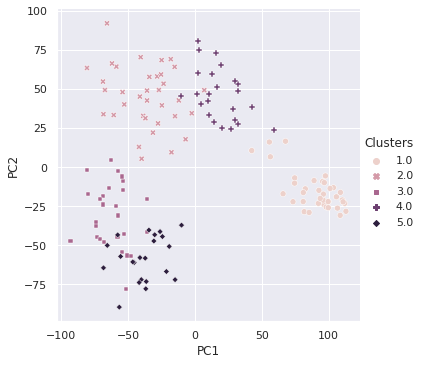

In [135]:

sns.relplot(x="PC1", y="PC2", data=pca_df, hue='Clusters', style='Clusters');
 
plt.show()

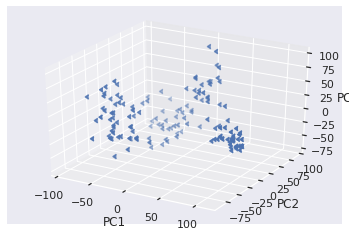

In [136]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pca_df['PC1'], pca_df['PC2'], pca_df['PC3'], marker=4)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')

plt.show()

Performing T-Distributed Stochastic Neighbor Embedding (tSNE) on PCA ...


Text(0, 0.5, 'tSNE2')

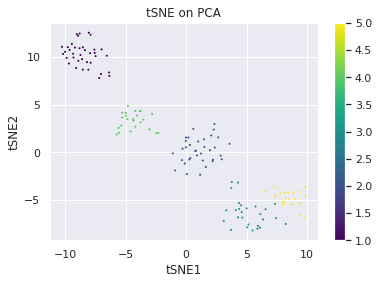

In [137]:
X = tDf.values[:,0:(tDf.shape[1]-1)]
Y = tDf.values[:,tDf.shape[1]-1]
print("Performing T-Distributed Stochastic Neighbor Embedding (tSNE) on PCA ...")
X_reduced = PCA(n_components = 30).fit_transform(X)
model = TSNE(learning_rate = 10, n_components = 2, random_state = 123, perplexity = 30)
tsne = model.fit_transform(X_reduced)
plt.scatter(tsne[:, 0], tsne[:, 1], c = Y, cmap = 'viridis', s = 1)
plt.title('tSNE on PCA')
plt.colorbar()
plt.xlabel("tSNE1")
plt.ylabel("tSNE2")

Performing T-Distributed Stochastic Neighbor Embedding (tSNE) ...


Text(0, 0.5, 'tSNE2')

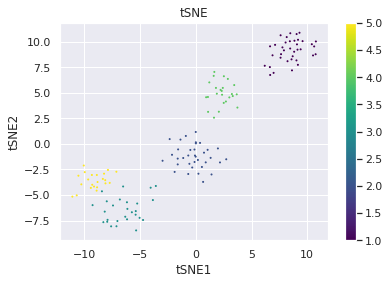

In [138]:
print("Performing T-Distributed Stochastic Neighbor Embedding (tSNE) ...")
model = TSNE(learning_rate = 10, n_components = 2, random_state = 123, perplexity = 30)
tsne = model.fit_transform(X)
plt.scatter(tsne[:, 0], tsne[:, 1], c = Y, cmap = 'viridis', s = 1)
plt.title('tSNE')
plt.colorbar()
plt.xlabel("tSNE1")
plt.ylabel("tSNE2")

Performing Uniform Manifold Approximation and Projection (UMAP) ...


Text(0, 0.5, 'UMAP2')

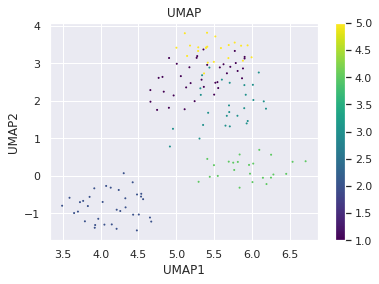

In [139]:
print("Performing Uniform Manifold Approximation and Projection (UMAP) ...")
model = UMAP(n_neighbors = 30, min_dist = 0.3, n_components =4 )
umap = model.fit_transform(X_reduced)
plt.scatter(umap[:, 0], umap[:, 1], c = Y, cmap = 'viridis', s = 1)
plt.title('UMAP')
plt.colorbar()
plt.xlabel("UMAP1")
plt.ylabel("UMAP2")

# Calculating som statistics from the Dataframe

First we will filter the samples using deseq2 and edgeR method based of cpm.
We will first calculate counts per million with unlogged values.

In [149]:
tDf = tDf.pop('Clusters')
transDf = tDf.transform(lambda x: 2**x)
tTransDf = transDf.transpose()
lista = list()
for sample in allClusters:
    lista.append(tTransDf[sample].sum()/1000000)
transDf['CPM'] = lista


Then create some new dataframes

In [154]:
print(transDf)
newDf = transDf.iloc[:,0:-1].div(transDf['CPM'], axis = 0)
transDf = transDf.drop(columns=['CPM'])
tTransDf = transDf.transpose()
pDf = pd.DataFrame()

TCGA-44-6148                                                    2
TCGA-50-5939                                                    2
TCGA-99-AA5R                                                    2
TCGA-49-6761                                                    2
TCGA-55-6971                                                    2
                                      ...                        
TCGA-05-4250                                                   32
TCGA-69-7978                                                   32
TCGA-55-A493                                                   32
TCGA-MP-A4TC                                                   32
CPM             [3.2e-05, 3.2e-05, 3.2e-05, 3.2e-05, 3.2e-05, ...
Name: Clusters, Length: 146, dtype: object


IndexingError: Too many indexers

Calculate the significance of each cluster usind independent t-test and FDR correction.

In [142]:
from bioinfokit.analys import get_data, stat
from scipy.stats import ttest_ind

clusterIndexes = list()
for i in range(len(clusters)):
    clusterIndexes.append(len(clusters['{}{}'.format(i+1, key)]))
    
start = 0
for counter, index in enumerate(clusterIndexes):
    index += start
    res = list()
    for i in range(tDf.shape[1]):
        res.append(ttest_ind(tDf.iloc[start:index, i].array, tDf.iloc[0:start].append(tDf.iloc[index:-1]).iloc[:,i].array)[1])
    pDf['Cluster {}'.format(counter+1)] = res
    start = index
#CORRECTED
import statsmodels as sm
for i in range(len(clusters)):
    tTransDf['Cluster {}'.format(i+1)] = sm.stats.multitest.fdrcorrection(pDf.iloc[:,i].array, alpha=0.05, method='indep', is_sorted=False)[1]

KeyError: '1_5C_Samples.txt'

Then get all significant genes.

We then filter based of a threshold using deseqs method.

In [89]:
genes = list()
for i in range(len(clusters)):
    genes.append(tTransDf[tTransDf['Cluster {}'.format(i+1)] < 0.025].index.tolist())
tList = list()
flag = 0
for i in range(len(clusters)):
    finalList = genes[i]
    lista = list()
    for gene in finalList:
        if  (newDf[gene].mean() > 100):
            lista.append(gene)
    tList.append(lista)

for genes in tList:
    print(len(genes))
    


630
471
490
290
416


We then calculate the significance of the genes inside a cluster compared to all the other clusters.
These are then saved into the newly created dataframe,

In [81]:
# num_plots = len(clusters)
# total_cols = 2
# total_rows = num_plots//total_cols + 1
# fig, axs = plt.subplots(nrows=total_rows, ncols=total_cols,
#                         figsize=(7*total_cols, 7*total_rows), constrained_layout=True)
# for i, var in enumerate(range(len(clusters))):
#     row = i//total_cols
#     pos = i % total_cols
#     plot = sns.clustermap(data = tDf.filter(items=tList[i]).transpose(), cmap = 'YlGnBu', metric = 'correlation', method = "average",vmax= 3, vmin = -3,col_cluster=False,ax=axs[row][pos])
    





In [82]:
sep = '|'
for i, genes in enumerate(tList):
    for j, gene in enumerate(genes):
        genes[j] = gene.split(sep,1)[0]
for i in range(len(clusters)):
    with open('cluster_{}_genes.txt'.format(i+1), 'w') as file:   
        file.write('\n'.join(tList[i]))

In [83]:
with open('all_genes.txt', 'w') as file:   
        file.write('\n'.join(tList[i]))

In [85]:
import json
import requests


ENRICHR_URL = 'http://maayanlab.cloud/Enrichr/addList'
genes_str = '\n'.join(tList[0])
description = 'Example gene list'
payload = {
    'list': (None, genes_str),
    'description': (None, description)
}

response = requests.post(ENRICHR_URL, files=payload)
if not response.ok:
    raise Exception('Error analyzing gene list')

data = json.loads(response.text)
print(data)

ConnectionError: HTTPConnectionPool(host='maayanlab.cloud', port=80): Max retries exceeded with url: /Enrichr/addList (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7fed9e70c250>: Failed to establish a new connection: [Errno -2] Name or service not known'))

In [ ]:
import json
import requests


ENRICHR_URL = 'http://maayanlab.cloud/Enrichr/view?userListId=%s'
user_list_id = data['userListId']
response = requests.get(ENRICHR_URL % user_list_id)
if not response.ok:
    raise Exception('Error getting gene list')
    
data = json.loads(response.text)
# print(data)

In [ ]:
ENRICHR_URL = 'http://maayanlab.cloud/Enrichr/enrich'
query_string = '?userListId=%s&backgroundType=%s'
gene_set_library = 'ChEA_2016'
response = requests.get(
    ENRICHR_URL + query_string % (user_list_id, gene_set_library)
 )
if not response.ok:
    raise Exception('Error fetching enrichment results')

data = json.loads(response.text)


In [ ]:
testDf = pd.DataFrame(data["ChEA_2016"])
testDf[2] = testDf[2].transform(lambda x: 1/x)
testDf[2] = np.log(testDf[2])
testDf
# testDf[2] = testDf[2].transform(lambda x: x /int(testDf[2].iloc[0:1]))

In [ ]:
testDf.filter(items=[1,2]).head().plot.bar(x = 1, y = 2)

In [ ]:
testDf.filter(items=[1,2]).head()

In [ ]:
ax = sns.barplot(x = 2, y = 1 , data = testDf.filter(items=[1,2]).head())

In [98]:
transDf.filter(items=tList[4]).transpose()

,TCGA-44-6148,TCGA-50-5939,TCGA-99-AA5R,TCGA-49-6761,TCGA-55-6971,TCGA-91-6835,TCGA-38-4632,TCGA-49-6745,TCGA-44-2668,TCGA-J2-A4AE,...,TCGA-83-5908,TCGA-55-6978,TCGA-64-1679,TCGA-05-4398,TCGA-44-3396,TCGA-55-7726,TCGA-05-4250,TCGA-69-7978,TCGA-55-A493,TCGA-MP-A4TC
SFTPA2|729238,11.619949,12.536533,5.420146,28.854711,41.178175,5.129501,28.000454,20.627771,20.911799,10.298343,...,0.051726,0.050984,0.005797,0.116606,0.197792,0.037307,1.283150,0.485887,0.048722,0.401842
SFTPC|6440,98.254985,126.522872,94.576156,169.466265,178.575333,59.246187,120.409382,273.978334,162.486799,1.325310,...,0.025825,0.054654,0.002467,0.289615,0.008127,0.003200,0.889193,0.124283,0.003246,0.004805
PGC|5225,14.753859,19.276493,11.721614,9.169361,14.850147,11.366168,9.724138,29.241242,32.565196,9.235768,...,0.039607,0.030030,0.027645,0.120243,0.030833,0.003019,0.785783,0.148723,0.018143,0.003096
SFTPA1|653509,12.327155,12.902675,6.880199,24.297782,31.987005,5.592892,27.788152,27.240236,17.778664,5.752121,...,0.046142,0.059576,0.002124,0.120231,0.194573,0.023629,1.124952,0.461269,0.036103,0.551735
SCGB3A1|92304,17.920073,4.442795,7.573781,3.050179,3.202425,5.119777,2.690696,19.292077,2.806692,176.178981,...,0.209016,0.253866,0.046424,0.396230,0.234010,0.099716,0.083735,0.308077,0.008332,2.346475
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ITLN2|142683,279.983888,192.880702,205.038412,354.905716,221.032545,62.171884,70.296185,586.766624,40.249139,0.461712,...,0.461712,0.461712,0.461712,0.461712,0.461712,0.461712,0.612415,0.461712,0.461712,1.050304
NPY1R|4886,10.664854,14.028887,4.310961,3.208220,4.779593,7.276770,1.530373,7.217498,0.930886,0.395209,...,0.188330,0.331239,0.121285,0.327219,0.336664,0.964179,2.633106,0.646439,0.445721,0.083587
ZFP42|132625,1.883200,5.512800,4.343100,3.112000,1.329800,2.505200,6.745300,13.284101,1.536100,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.008700,1.000000,20.473200
LRRC48|83450,35.583670,0.589497,0.791536,1.319210,0.914116,50.148634,1.722249,20.570235,0.692431,4.651843,...,1.381026,0.866760,0.478758,1.304641,0.607583,0.243981,0.421692,0.728098,0.266587,0.234560


In [84]:
df = pd.DataFrame({'Column 1': [2,4,4], 'Column 2':[2,2,4]})

In [89]:
lista = [0]
retDict = dict()
df = df.transpose().filter(items=lista).transpose()
for column in list(df.columns):
    if tuple(df[column].values) in retDict:
        retDict[tuple(df[column].values)] = retDict[tuple(df[column].values)]+1
    else:
        retDict[tuple(df[column].values)] = 1
    

,Column 1,Column 2
0,2,2


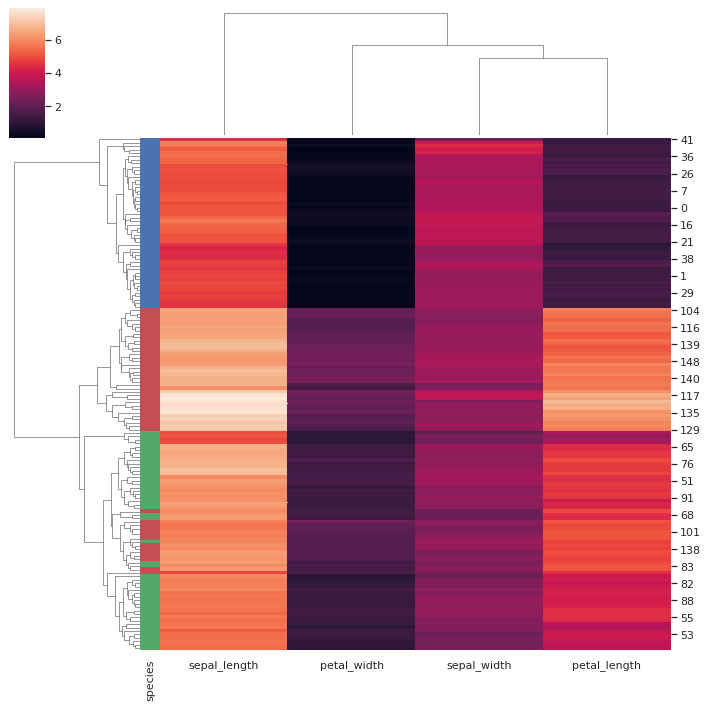

In [19]:
import seaborn as sns; sns.set_theme(color_codes=True)
iris = sns.load_dataset("iris")
species = iris.pop("species")
lut = dict(zip(species.unique(), 'bgrcmykw'))
row_colors = species.map(lut)
# row_colors = species
g = sns.clustermap(iris, row_colors=row_colors)

{1.0: 'r', 2.0: 'g', 3.0: 'b'}